In [3]:
a=np.load("123.npy")
# for i in range(a.shape[1]):
#     for j in range(a.shape[2]):
#         print(a[:,i,j])


NameError: name 'np' is not defined

In [2]:
a.shape

NameError: name 'a' is not defined

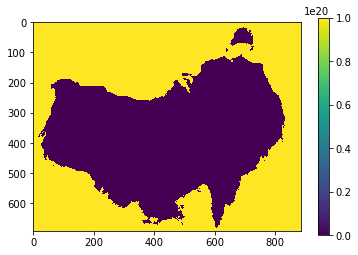

In [30]:
a_mean=a.mean(axis=0)
import matplotlib.pyplot as plt
plt.imshow(a[0])
plt.colorbar()
# log(1+x);package,system; 询问敏哲情况；

In [1]:
import torch
from datetime import date,timedelta
import numpy as np
import data_processing_tool as dpt
from torchvision import datasets, models, transforms
from PIL import Image
net=torch.load("../data/model/vsdr_12h/best_train.pth")
net=torch.load("./save/vdsr_pr/best_test.pth")#测试 my

from statsmodels.distributions.empirical_distribution import ECDF
import xarray as xr
def crps(ensin,obs):
    '''
    @param ensin A vector of prediction
    @param obs  A vector of observations
    
'''

#     assert not np.isnan(ensin).any() and not np.isnan(obs).any(), "data contains nan"
         
    Fn = ECDF(ensin)
    xn=np.sort(np.unique(ensin))
    m=len(xn)
    dn=np.diff(xn)
    eq1=0
    eq2=0
    if(obs>xn[0] and obs<xn[m-1]): #obs在范围内
        k=np.max(np.where(xn<=obs))#小于obs的最大值下标
        x0 = xn[k] #小于obs的最大值
        if k>0:
            eq1=np.sum(Fn(xn[0:k+1])**2*np.append(dn[0:k], obs - xn[k]))#小于obs的所有值 的 百分比数 的平方
        else:
            eq1 =np.sum(Fn(xn[0])**2*(obs - xn[0]))
        if k<m-2:

            eq2=np.sum((1-Fn(xn[k:m-1]))**2*np.append(xn[k+1] - obs, dn[(k+1):(m-1)]))
        else:
            eq2 =np.sum((1-Fn(xn[m-2]))**2*(xn[m-1] - obs))

    if obs <= xn[0]: # 观测值在之外
        eq2 =np.sum(np.append(1, 1-Fn(xn[0:(m-1)]))**2*np.append(xn[0]-obs, dn))
    if obs >= xn[m-1]:
        eq1= np.sum(Fn(xn)**2*np.append(dn, obs - xn[m-1]))
            
    return eq1+eq2 




def vectcrps_v(fct_ens,obs):
    '''
    #' @param fct_ens A 2D prediction
    #' @param obs  A vector of observations
    #' @return a crps vector'''
    score =0

    
    fct_ens=fct_ens
    assert not np.isnan(fct_ens).any() and not np.isnan(obs).any(),"data contains nan"
    for i in range(obs.shape[0]):
#         print(fct_ens[:,i],obs[i])
        score+=crps(fct_ens[:,i],obs[i])
  
    return score


def vectcrps_m(fct_ens,obs):
    '''
    #' @param fct_ens A 2D prediction
    #' @param obs  A vector of observations
    #' @return a crps vector'''
    score =0
    assert not np.isnan(fct_ens).any() and not np.isnan(obs).any(),"data contains nan"
    score_map=np.zeros((obs.shape[0],obs.shape[1]))
    for i in range(obs.shape[0]):
        for j in range(obs.shape[1]):
            score_map[i,j]=crps(fct_ens[:,i,j],obs[i,j])
#             score+=crps(fct_ens[:,i,j],obs[i,j])
    return score_map
    return score/(obs.shape[0]*obs.shape[1])

dem=dpt.read_dem("../DEM/"+"dem-9s1.tif")

In [1]:
# draw access data origin
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from libtiff import TIFF
import os, sys
import numpy as np

from datetime import datetime
from datetime import timedelta

import matplotlib
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
# import cartopy.crs as ccrs
from matplotlib import cm
# from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings("ignore")
from matplotlib.backends.backend_pdf import PdfPages

levels = {}
levels["loss"]  = [0., 0.01,   0.02,   0.05,  0.1,  0.5,  1,   5,   10,   20,  50,  100]
levels["hour"]  = [0., 0.2,   1,   5,  10,  20,  30,   40,   60,   80,  100,  150]
levels["day"]   = [0., 0.2,  5, 10,  20,  30,  40,  60,  100,  150,  200,  300]
levels["week"]  = [0., 0.2,  10,  20,  30,  50, 100,  150,  200,  300,  500, 1000]
levels["month"] = [0.,  10,  20,  30,  40,  50, 100,  200,  300,  500, 1000, 1500]
levels["year"]  = [0.,  50, 100, 200, 300, 400, 600, 1000, 1500, 2000, 3000, 5000]
enum={0:"0600",1:"1200",2:"1800",3:"0000",4:"0600"}


prcp_colours_0 = [
                   "#FFFFFF", 
                   '#ffffd9',
                   '#edf8b1',
                   '#c7e9b4',
                   '#7fcdbb',
                   '#41b6c4',
                   '#1d91c0',
                   '#225ea8',
                   '#253494',
                   '#081d58',
                   "#4B0082"]

prcp_colours = [
                   "#FFFFFF", 
                   '#edf8b1',
                   '#c7e9b4',
                   '#7fcdbb',
                   '#41b6c4',
                   '#1d91c0',
                   '#225ea8',
                   '#253494',
                   '#4B0082',
                   "#800080",
                   '#8B0000']
prcp_colormap = matplotlib.colors.ListedColormap(prcp_colours)
# -32.0 118.0
#Perth domain=[112.00,124.00,-37.00,-26.99]
# [112.9, 154.25, -43.7425, -9.0]
def draw_aus(var,lat,lon,domain = [112.9, 154.25, -43.7425, -9.0], level="day" ,titles_on = True, title = "BARRA-R precipitation", colormap = prcp_colormap, cmap_label = "Precipitation (mm)",save=False,path=""):
    """ basema_ploting .py
This function takes a 2D data set of a variable from BARRA and maps the data on miller projection. 
The map default span is longitude between 111E and 155E, and the span for latitudes is -45 to -30, this is SE Australia. 
The colour scale is YlGnBu at 11 levels. 
The levels specifed are suitable for annual rainfall totals for SE Australia. 
From the BARRA average netCDF, the mean prcp should be multiplied by 24*365
"""
#    lats.sort() #this doesn't do anything for BARRA
#    lons.sort() #this doesn't do anything for BARRA
#     domain = [111.975, 156.275, -44.525, -9.975]#awap
    from matplotlib.colors import ListedColormap, BoundaryNorm
    from mpl_toolkits.basemap import Basemap
#     fig=plt.figure(dpi=100)
    level=levels[level]
    map = Basemap(projection = "mill", llcrnrlon = domain[0], llcrnrlat = domain[2], urcrnrlon = domain[1], urcrnrlat = domain[3], resolution = 'l')
    map.drawcoastlines()
    map.drawmapboundary()
    map.drawparallels(np.arange(-90., 120., 10.),labels=[1,0,0,0])
    map.drawmeridians(np.arange(-180.,180., 10.),labels=[0,0,0,1])
    llons, llats = np.meshgrid(lon, lat) # 将维度按照 x,y 横向竖向
#     print(lon.shape,llons.shape)
    x,y = map(llons,llats)
#     print(x.shape,y.shape)
    
    norm = BoundaryNorm(level, len(level)-1)
    data=xr.DataArray(var,coords=[lat,lon],dims=["lat","lon"])
    cs = map.pcolormesh(x, y, data, norm = norm, cmap = colormap) 

    
    if titles_on:
        # label with title, latitude, longitude, and colormap
        
        plt.title(title)
        plt.xlabel("\nLongitude")
        plt.ylabel("Latitude\n\n")
        cbar = plt.colorbar(ticks = level[:-1], shrink = 0.8, extend = "max",orientation='vertical')
        cbar.ax.set_ylabel(cmap_label)
        cbar.ax.set_xticklabels(level)
    if save:
        plt.savefig(path)
        pdf = PdfPages(path+'.pdf')
        pdf.savefig()
        pdf.close() 
    else:
        plt.show()
    plt.cla()
    plt.close("all")
    
    return plt.show()
def add_lat_lon_data(data,domain=[112.9, 154.25, -43.7425, -9.0],xarray=True):
    "data: is the something you want to add lat and lon, with first demenstion is lat,second dimention is lon,domain is DEM domain "
    new_lon=np.linspace(domain[0],domain[1],data.shape[1])
    new_lat=np.linspace(domain[2],domain[3],data.shape[0])
    if xarray:
        return xr.DataArray(data,coords=[new_lat,new_lon],dims=["lat","lon"])
    else:
        return data,new_lat,new_lon

# -32.0 118.0
#Perth domain=[112.00,124.00,-37.00,-26.99]
# [112.9, 154.25, -43.7425, -9.0]

from netCDF4 import Dataset, num2date, date2num
filename="../data/da_pr_19900125_e01.nc"
demo_date=date(1990,1,25)

idx=0
ensamble_demo="e01"
file="../data/"
demo_date=date(1990,1,25)
data = Dataset(filename, 'r')
# day30=data["pr"][0]*86400
day30=dpt.read_access_data(root_dir="../data/",en=ensamble_demo,date_time=demo_date,leading=7)
day30=add_lat_lon_data(day30)*86400
lat=data["lat"][:]
lon=data["lon"][:]
# domain=[lon[0], lon[-1], lat[0], lat[-1]]
domain=[112.00,124.00,-37.00,-26.99]
# domain=[112.00,124.00,-32.00,-26.99]

day30,lat,lon=add_lat_lon_data(day30,xarray=False)
# title="lr \n date: "+(demo_date+timedelta(idx)).strftime("%Y%m%d")
draw_aus(day30,lat,lon,title="",domain=domain,save=False,path="thesis")

NameError: name 'date' is not defined

In [73]:
data = Dataset("../data/accum_prcp-an-spec-PT0H-BARRA_R-v1.1-20100201T0000Z.nc", 'r')

In [74]:
data["accum_prcp"]#kg m-2 s-1

<class 'netCDF4._netCDF4.Variable'>
float64 accum_prcp(latitude, longitude)
    _FillValue: -1073741824.0
    standard_name: precipitation_amount
    units: kg m-2
    um_stash_source: m01s05i226
    grid_mapping: latitude_longitude
    coordinates: forecast_period forecast_reference_time time
    cell_methods: time: sum
    long_name: TOTAL PRECIPITATION AMOUNT  KG/M2/TS
    stash_code: 5226
    wgdos_packing_accuracy: None
    stash_comments: Total precipitation amount at the surface in kg/m2 per timestep. This is the sum of the large scale and convective rainfall and snowfall at the surface. You are advised to used 216 instead.
    stash_description: TOTAL PRECIPITATION AMOUNT  KG/M2/TS
    description: Total precipitation amount at the surface. This is the sum of the large scale rainfall, convective rainfall and snowfall at the surface.
    MD5: 54b653fd2ae4661a1192f4bd151abd50
unlimited dimensions: 
current shape = (768, 1200)
filling on

In [55]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    source: Data from Met Office Unified Model
    um_version: 10.2
    Conventions: CF-1.6, ACDD-1.3
    institution: Australian Bureau of Meteorology, GPO Box 1289, Melbourne VIC 3001, Australia
    title: Bureau of Meteorology Atmospheric high-resolution Regional Reanalysis for Australia (BARRA)
    summary: The Bureau of Meteorology Atmospheric high-resolution Regional Reanalysis for Australia (BARRA) is a high-resolution multi-decadal atmospheric reanalysis. The reanalysis suite is based on the Australian Community Climate Earth-System Simulator (ACCESS) and extends 70 levels (up to 80 km) into the atmosphere. It is nested within the required boundary and/or initial conditions provided by ERA-Interim reanalysis, Operational SST and Sea Ice Analysis, and the Bureau offline soil moisture reanalysis. The region covered by the reanalysis is the Australian continent, and the surrounding region includi

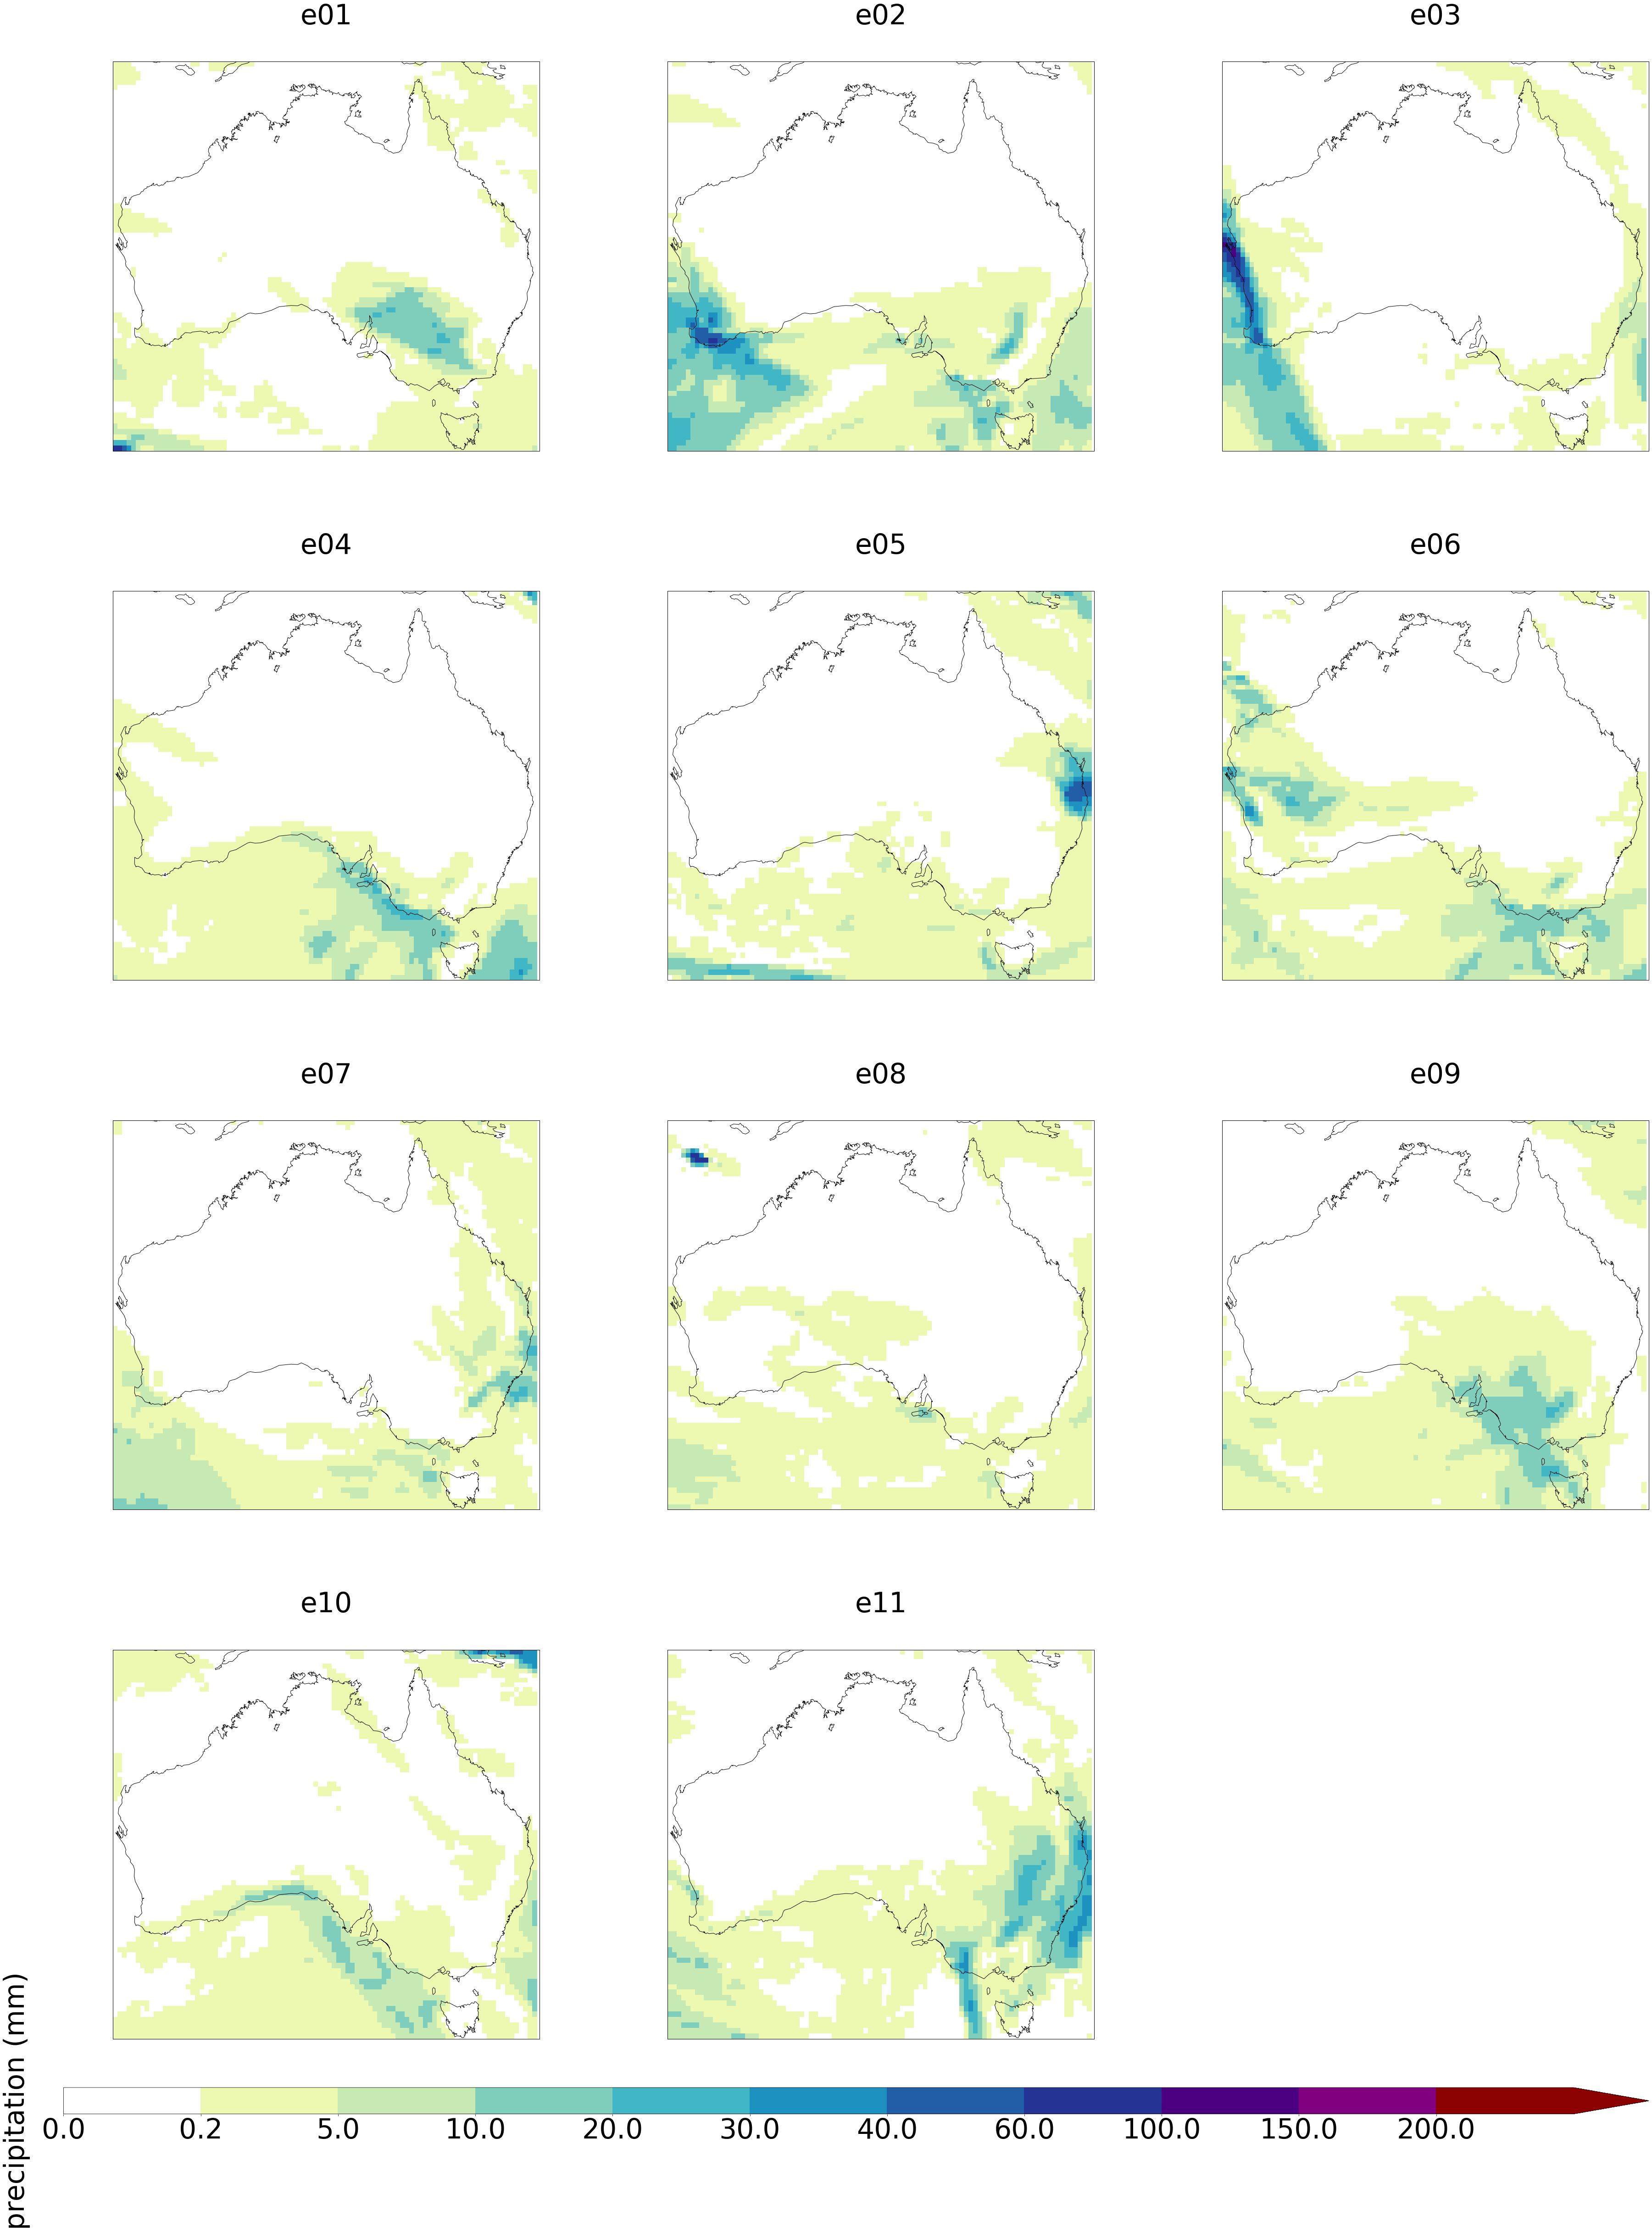

In [37]:
# 画子图
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.basemap import Basemap
colormap = prcp_colormap
domain = [112.9, 154.25, -43.7425, -9.0]    
demo_date=datetime(2012,6,25)
leading_time=20
ensemble_access=['e01','e02','e03','e04','e05','e06','e07','e08','e09','e10','e11']
pdf = PdfPages('ensemble_'+str(leading_time)+'.pdf')
fig=plt.figure(figsize=(60, 80))


# axes=plt.subplots(1,11,figsize=(10,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for i,e in enumerate(ensemble_access):
    day30=dpt.read_access_data(root_dir="../data/",en=e,date_time=demo_date,leading=leading_time)
    day30=add_lat_lon_data(day30)*86400
    day30,lat,lon=add_lat_lon_data(day30,xarray=False)
#     axes[0,i]
    ax = fig.add_subplot(4,3,i+1)
    level=levels["day"]
    map = Basemap(projection = "mill", llcrnrlon = domain[0], llcrnrlat = domain[2], urcrnrlon = domain[1], urcrnrlat = domain[3], resolution = 'l')
    map.drawcoastlines()
    map.drawmapboundary()
#     map.drawparallels(np.arange(-90., 120., 10.),labels=[1,0,0,0],linewidth=5)
#     map.drawmeridians(np.arange(-180.,180., 10.),labels=[0,0,0,1])
    llons, llats = np.meshgrid(lon, lat) # 将维度按照 x,y 横向竖向
#     print(lon.shape,llons.shape)
    x,y = map(llons,llats)
#     print(x.shape,y.shape)
    
    norm = BoundaryNorm(level, len(level)-1)
    data=xr.DataArray(day30,coords=[lat,lon],dims=["lat","lon"])
    cs = map.pcolormesh(x, y, data, norm = norm, cmap = colormap) 
    plt.title(e+"\n",fontsize=60)
    
cbar_ax = plt.gcf().add_axes([0.1,0.1, 0.8, 0.01])
# plt.colorbar(cax=cbar_ax)
cb=plt.colorbar(cax=cbar_ax,ticks = level[:-1], shrink = 0.8, extend = "max",orientation='horizontal')
cb.ax.tick_params(labelsize=60)
cb.ax.set_ylabel("precipitation (mm)\n",fontsize=60)
# cbar.ax.set_xticklabels(level,fontsize=20)
# plt.rcParams['font.size'] = 15
# plt.show()

# plt.savefig(path)
plt.savefig('ensemble_'+str(leading_time))
pdf.savefig()
pdf.close()   

In [26]:
data

<xarray.DataArray (lat: 79, lon: 94)>
array([[ 3.79713454e-01,  2.51677100e-01,  8.08858551e-02, ...,
         4.61054819e+00,  5.27654048e+00,  5.55207962e+00],
       [ 2.09764566e-01,  1.56989654e-01,  9.15505974e-02, ...,
         5.52133333e+00,  7.83618574e+00,  9.30725564e+00],
       [ 1.30613907e-01,  1.41972421e-01,  1.55740463e-01, ...,
         9.71355310e+00,  1.16094371e+01,  1.28394320e+01],
       ...,
       [ 2.17752364e+01,  2.08464218e+01,  1.92688328e+01, ...,
         1.98829231e+00,  1.57848655e+00,  1.34930589e+00],
       [ 2.63710675e+01,  2.54528744e+01,  2.37338433e+01, ...,
         3.26734706e-02, -2.55096003e-02, -3.03180273e-02],
       [ 3.46898465e+01,  3.26881299e+01,  2.91302685e+01, ...,
        -3.64736257e-02, -2.75238920e-02, -2.27080024e-02]])
Coordinates:
  * lat      (lat) float64 -43.74 -43.3 -42.85 -42.41 ... -9.891 -9.445 -9.0
  * lon      (lon) float64 112.9 113.3 113.8 114.2 ... 152.7 153.1 153.6 154.0

In [ ]:
# 画子图
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.basemap import Basemap
colormap = prcp_colormap
domain = [112.9, 154.25, -43.7425, -9.0]    
demo_date=datetime(1990,1,25)
leading_time=1
ensemble_access=['e01','e02','e03','e04','e05','e06','e07','e08','e09','e10','e11']
for i,e in enumerate(ensemble_access):
    day30=dpt.read_access_data(root_dir="../data/",en=e,date_time=demo_date,leading=leading_time)
    day30=add_lat_lon_data(day30)*86400
    day30,lat,lon=add_lat_lon_data(day30,xarray=False)
    draw_aus(day30,lat,lon,title="",save=True,path=e+"_"+str(leading_time))    

    

In [ ]:
demo_date=date(1990,1,25)
hhr,lat,lon=dpt.read_barra_data_fc_get_lat_lon("../data/barra_aus/",demo_date,e)
draw_aus(hhr,lat,lon,save=True,path="prdem_HR")

torch.Size([1, 1, 316, 376])
-0.026927471160888672
(316, 376)


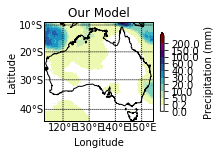

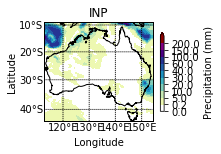

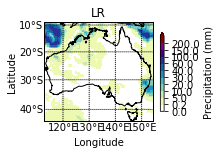

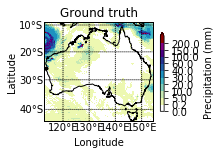

In [11]:
import time
net=torch.load("../data/model/vsdr_12h/best_train.pth")
# net=torch.load("./save/vdsr_pr/best_test.pth")#测试 my
def add_lat_lon_data(data,domain=[112.9, 154.00, -43.7425, -9.0],xarray=True):
    "data: is the something you want to add lat and lon, with first demenstion is lat,second dimention is lon,domain is DEM domain "
    new_lon=np.linspace(domain[0],domain[1],data.shape[1])
    new_lat=np.linspace(domain[2],domain[3],data.shape[0])
    if xarray:
        return xr.DataArray(data,coords=[new_lat,new_lon],dims=["lat","lon"])
    else:
        return data,new_lat,new_lon
    
def prepare( l, volatile=False):
    def _prepare(tensor):
#         if args.precision == 'half': tensor = tensor.half()
#         if args.precision == 'single': tensor = tensor.float()
        return tensor.to(device)

    return [_prepare(_l) for _l in l]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# demo_date=date(2012,6,25)
demo_date=date(1990,1,25)

idx=0
ensamble_demo="e01"
file="../data/"
# pr=np.expand_dims(np.repeat(np.expand_dims( dpt.read_access_data(file,ensamble_demo,demo_date,idx)    ,axis=0)  ,1,axis=0),axis=0)
# pr=np.expand_dims(np.repeat(np.expand_dims( dpt.read_access_data(file,ensamble_demo,demo_date,idx)    ,axis=0)  ,1,axis=0),axis=0)
# pr=np.expand_dims(dpt.read_access_data(file,ensamble_demo,demo_date,idx),axis=2)
pr_raw=dpt.read_access_data(file,ensamble_demo,demo_date,idx)
pr_label=dpt.read_barra_data_fc_get_lat_lon("../data/barra_aus/",demo_date)

lr_transforms = transforms.Compose([
    transforms.Resize((316, 376)),
#     transforms.RandomResizedCrop(IMG_SIZE),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(30),
    transforms.ToTensor()
#     transforms.Normalize(IMG_MEAN, IMG_STD)
])

dem_transforms = transforms.Compose([
#     transforms.RandomResizedCrop(IMG_SIZE),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(30),
    transforms.ToTensor()
#     transforms.Normalize(IMG_MEAN, IMG_STD)
])

pr=lr_transforms(Image.fromarray(pr_raw))
pr=pr.numpy()
pr=np.expand_dims(pr,axis=0)
# print(torch.Tensor.expand(pr).shape)


dem_data=add_lat_lon_data( dem)
dem_data=dpt.interp_tensor_2d(dpt.map_aust_old(dem_data,xrarray=False) ,(316, 376) )
dem_data=dem_data[:,:,np.newaxis]
dem_data=dem_transforms(dem_data)
dem_data=dem_data[np.newaxis]

start=time.time()

pr_raw=dpt.read_access_data(file,ensamble_demo,demo_date,0)
pr=lr_transforms(Image.fromarray(pr_raw))
pr=pr.numpy()
pr=np.expand_dims(pr,axis=0)
pr=prepare([torch.tensor(pr),torch.tensor(dem_data)])
print(pr[0].shape)
# hr=net(pr[0],pr[1]).cpu().detach().numpy()
start=time.time()
hr=net(pr[0]*86400).cpu().detach().numpy()
print(start-time.time())
# print(hr.shape)
print(np.squeeze(hr[:,0]).shape)




plt.figure()

plt.subplot(221)
title=""
# prec_in=dpt.read_access_data(filename,idx=idx)*86400
hr,lat,lon=add_lat_lon_data(np.squeeze(hr[:,0]),xarray=False)
# print(hr)
draw_aus(hr,lat,lon,title="Our Model",save=False,path="prdem_sr")
plt.subplot(222)
hr_inter=dpt.interp_tensor_2d(pr_raw,(316, 376))
draw_aus(hr_inter*86400,lat,lon,title="INP",save=False,path="prdem_hr_inter")

plt.subplot(223)
hr,lat,lon=add_lat_lon_data(pr_raw,xarray=False)
title="lr \n date: "+(demo_date+timedelta(idx)).strftime("%Y%m%d")
draw_aus(pr_raw*86400,lat,lon,title="LR",save=False,path="prdem_lr")

plt.subplot(224)
title="lr \n date: "+(demo_date+timedelta(idx)).strftime("%Y%m%d")
draw_aus(pr_label[0],pr_label[1],pr_label[2],title="Ground truth",save=False,path="prdem_label")
plt.show()

In [14]:
hr_inter

array([[8.56367205e-06, 8.57914620e-06, 8.64505000e-06, ...,
        1.10104324e-07, 1.14648053e-07, 1.15686959e-07],
       [8.61123408e-06, 8.62928664e-06, 8.70624262e-06, ...,
        1.07357579e-07, 1.11793405e-07, 1.12807648e-07],
       [8.81541564e-06, 8.84573001e-06, 8.97526388e-06, ...,
        9.50935188e-08, 9.90306361e-08, 9.99308725e-08],
       ...,
       [3.10438394e-04, 3.09474475e-04, 3.05401278e-04, ...,
        1.48760431e-04, 1.44781428e-04, 1.43838624e-04],
       [2.92369892e-04, 2.91513628e-04, 2.87911418e-04, ...,
        1.49176572e-04, 1.45566126e-04, 1.44708290e-04],
       [2.88260606e-04, 2.87428382e-04, 2.83931819e-04, ...,
        1.49311891e-04, 1.45778133e-04, 1.44937963e-04]], dtype=float32)

In [ ]:
# def read_access_data_get_lat_lon_1(root_dir,en,date_time,leading,var_name="pr"):
#     filename=root_dir+var_name+"_30/daily/"+en+"/"+"da_"+var_name+"_"+date_time.strftime("%Y%m%d")+"_"+en+".nc"
#     data = Dataset(filename, 'r')
#     var = data[var_name][leading]
#     lats = data['lat'][:]
#     lons = data['lon'][:]
#     data.close()
#     return var,lats,lons
from netCDF4 import Dataset, num2date, date2num
filename="../data/calibrated/daq5_pr_19900101_e01.nc"
data = Dataset(filename, 'r')
day30=data["pr"][1]
day30,lat,lon=add_lat_lon_data(day30,xarray=False)
title="lr \n date: "+(demo_date+timedelta(idx)).strftime("%Y%m%d")
dpt.draw_aus(day30,lat,lon,title=title,save=False,path="prdem_lr")

In [ ]:
day30,lat,lon=dpt.read_access_data_get_lat_lon_30(file,ensamble_demo,demo_date,idx)
# day30*84000
day30,lat,lon=add_lat_lon_data(day30,xarray=False)
title="lr \n date: "+(demo_date+timedelta(idx)).strftime("%Y%m%d")
dpt.draw_aus(day30*84000,lat,lon,title=title,save=True,path="prdem_lr")

In [ ]:
a=12312313
b

In [ ]:

a=np.random.rand(123,123,3)
dem_transforms(a).shape

In [ ]:
dem_data.shape

In [ ]:

dem_data=add_lat_lon_data( dem)
dem_data=dpt.interp_tensor_2d(dpt.map_aust_old(dem_data,xrarray=False) ,(316, 376) )

In [ ]:
diff=abs(hr[0]-np.array(hhr[0]))
diff.mean()

# leading time 7-10 ；另外一个模型30天， （份不同的模型）
#每一天 crps socore 画图boxplot

如果187天，2011的6月份
2012.1,1 187天
2012,12,31 

30,40,50趋势图
# 闰年
# interpolation，rcan， VDSR 
# select pixel， 海边